# DL-Assignment-1
Authors: 

Harsha Vishak : 2019A7PS0079G

Aastha Rastogi : 2019A7PS0175G

Athreya Krishnan : 2018B4A70809G

Contributions : Equal

# Part 1

We first create two MLPs; one without skip connections and one with skip connections. We then run these two models on both the MNIST and CIFAR-10 datasets. Finally, we compare their performance on both. 



In [ ]:
#importing the required modules
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from torch.utils.data import random_split
import numpy as np

In [ ]:
train_dataset_CIFAR = dsets.CIFAR10(root = './',train = True, transform = transforms.ToTensor(),download = True)
train_dataset_MNIST = dsets.MNIST(root = './',train = True, transform = transforms.ToTensor(),download = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
test_dataset_CIFAR = dsets.CIFAR10(root = './',train = False , transform = transforms.ToTensor(),download = True)
test_dataset_MNIST = dsets.MNIST(root = './',train = False , transform = transforms.ToTensor(),download = True)

Files already downloaded and verified


We split the training set into two parts; the train set and the validation set. The size of the validation set is 5000 samples for both datasets, the training set for MNIST has 55000 samples, and CIFAR-10 has 45000 samples.

In [ ]:
#we split the training data into training and validation set
torch.manual_seed(43)
val_size = 5000

train_size_CIFAR = len(train_dataset_CIFAR) - val_size
train_size_MNIST = len(train_dataset_MNIST) - val_size

train_dataset_CIFAR, val_dataset_CIFAR = random_split(train_dataset_CIFAR, [train_size_CIFAR, val_size])
train_dataset_MNIST,val_dataset_MNIST =  random_split(train_dataset_MNIST, [train_size_MNIST, val_size])

In [ ]:
#we now load segment the data into batches
batch_size = 100
train_loader_CIFAR = torch.utils.data.DataLoader(dataset = train_dataset_CIFAR,batch_size = batch_size , shuffle = True)
test_loader_CIFAR = torch.utils.data.DataLoader(dataset = test_dataset_CIFAR , batch_size = batch_size , shuffle = False)
train_loader_MNIST = torch.utils.data.DataLoader(dataset = train_dataset_MNIST,batch_size = batch_size , shuffle = True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset = test_dataset_MNIST , batch_size = batch_size , shuffle = False)
validation_loader_MNIST = torch.utils.data.DataLoader(dataset = val_dataset_MNIST,batch_size = batch_size , shuffle = True)
validation_loader_CIFAR = torch.utils.data.DataLoader(dataset = val_dataset_CIFAR , batch_size = batch_size , shuffle = True)


We now define the class for our MLP, taking a model with 5 hidden layers. We also define the class for the MLP with skip connections, which has the same number of hidden layers, but each layer is connected to all the previous hidden layers.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.ReLu(out)
        out = self.fc2(out)
        out = self.ReLu(out)
        out = self.fc3(out)
        out = self.ReLu(out)
        out = self.fc4(out)
        out = self.ReLu(out)
        out = self.fc5(out)
        out = self.ReLu(out)
        out = self.fc6(out)
        out = self.ReLu(out)
        out = self.fc_final(out)
        return out

In [ ]:
class MLP_with_skip(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_skip, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3+out)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+out+out2)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out+out2+out4)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out+out2+out4+out6)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x)
        return out_final

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


We now create instances of the above models, with 300 neurons in each hidden layers. We choose cross entropy loss since it is a classification problem.

In [ ]:
input_CIFAR = 3*32*32
input_MNIST = 28*28
hidden_dim = 300

output_dim = 10
torch.manual_seed(0)
model_without_skip_CIFAR = MLP(input_CIFAR, hidden_dim,output_dim)
model_with_skip_CIFAR = MLP_with_skip(input_CIFAR, hidden_dim ,output_dim)
model_without_skip_MNIST = MLP(input_MNIST, hidden_dim,output_dim)
model_with_skip_MNIST = MLP_with_skip(input_MNIST, hidden_dim ,output_dim)  
if torch.cuda.is_available():
    model_with_skip_CIFAR.to(device)
    model_without_skip_CIFAR.to(device)
    model_with_skip_MNIST.to(device)
    model_without_skip_MNIST.to(device)   

We now create a function to train the model which we can use again later when using the modified model with skip connections. It takes in a list to store the loss values at each iteration.

In [ ]:
def train(model,epochs,train_loader,validation_loader,input_size,loss_list):
  iter = 0
  criterion = nn.CrossEntropyLoss()
  learning_rate = 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay=1e-5)


  for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, input_size).requires_grad_()
 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        if(iter%10==0):
          loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        iter += 1
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(-1, input_size).requires_grad_()

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
              
                correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

We now create a function to test the model on the test set.

In [ ]:
def test(model,test_loader,input_size):
  correct = 0
  total = 0
  for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    images = Variable(images.view(-1,input_size))
    output = model(images)
    _,predicted = torch.max(output.data,1)
    total+=labels.size(0)
    correct += (predicted==labels).sum()
  accuracy = (correct.item()/total)*100
  print(" Test Accuracy = ",accuracy)

In [ ]:
loss_list_withoutskip_CIFAR = []
loss_list_with_skip_CIFAR = []

print("Model without skips on CIFAR10--------------------")
train(model_without_skip_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_list_withoutskip_CIFAR)
print("Model with skips on CIFAR10--------------------")
train(model_with_skip_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_list_with_skip_CIFAR)

loss_list_withoutskip_MNIST = []
loss_list_with_skip_MNIST = []
print("Model without skips on MNIST--------------------")
train(model_without_skip_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_list_withoutskip_MNIST)
print("Model with skips on MNIST--------------------")
train(model_with_skip_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_list_with_skip_MNIST)

Model without skips on CIFAR10--------------------
Iteration: 500. Loss: 2.189284563064575. Accuracy: 13.56
Iteration: 1000. Loss: 2.106480836868286. Accuracy: 22.52
Iteration: 1500. Loss: 2.0090553760528564. Accuracy: 23.44
Iteration: 2000. Loss: 1.6730974912643433. Accuracy: 30.64
Iteration: 2500. Loss: 1.6789865493774414. Accuracy: 32.58
Iteration: 3000. Loss: 1.6863359212875366. Accuracy: 36.64
Iteration: 3500. Loss: 1.4544090032577515. Accuracy: 40.42
Iteration: 4000. Loss: 1.6518182754516602. Accuracy: 39.36
Iteration: 4500. Loss: 1.767096996307373. Accuracy: 41.7
Model with skips on CIFAR10--------------------
Iteration: 500. Loss: 1.7638881206512451. Accuracy: 29.74
Iteration: 1000. Loss: 1.6308579444885254. Accuracy: 35.64
Iteration: 1500. Loss: 1.7705464363098145. Accuracy: 39.04
Iteration: 2000. Loss: 1.7435721158981323. Accuracy: 37.86
Iteration: 2500. Loss: 1.3442022800445557. Accuracy: 43.5
Iteration: 3000. Loss: 1.259359359741211. Accuracy: 43.9
Iteration: 3500. Loss: 1.

In [ ]:
print("Model without skips on CIFAR10--------------------")
test(model_without_skip_CIFAR,test_loader_CIFAR,input_CIFAR)
print("Model with skips on CIFAR10--------------------")
test(model_with_skip_CIFAR,test_loader_CIFAR,input_CIFAR)
print("Model without skips on MNIST--------------------")
test(model_without_skip_MNIST,test_loader_MNIST,input_MNIST)
print("Model with skips on MNIST--------------------")
test(model_with_skip_MNIST,test_loader_MNIST,input_MNIST)

Model without skips on CIFAR10--------------------
 Test Accuracy =  42.78
Model with skips on CIFAR10--------------------
 Test Accuracy =  48.99
Model without skips on MNIST--------------------
 Test Accuracy =  97.48
Model with skips on MNIST--------------------
 Test Accuracy =  97.69


We see that for CIFAR10, the model with skips has around 6% better accuracy on the test data, clearly showing that skip connections have a sizable impact on the accuracy. We now plot the graphs comparing the loss of the models verus the number of training iterations.

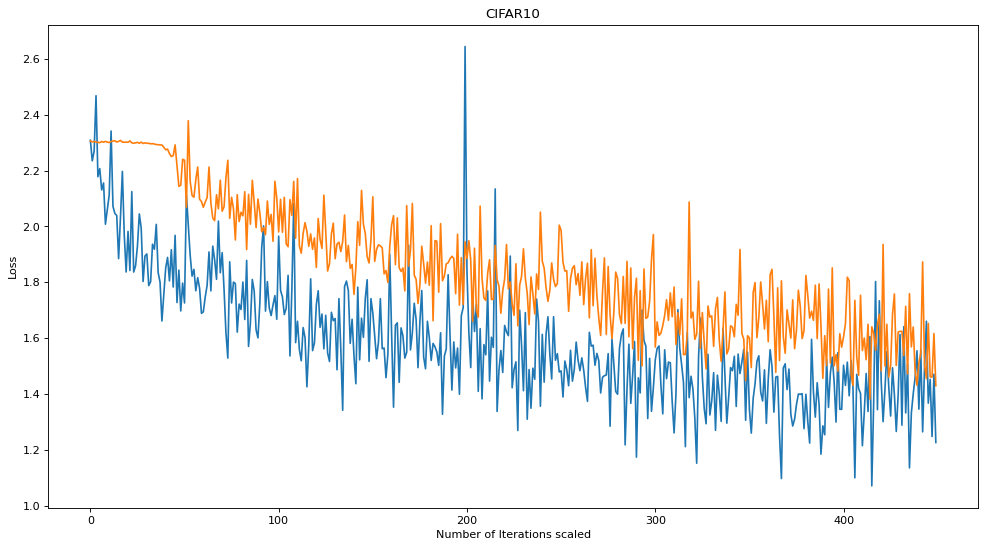

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 8), dpi=80)


l1 = np.array(loss_list_with_skip_CIFAR)
l2 = np.array(loss_list_withoutskip_CIFAR)

iter_list = np.arange(450)

plt.plot(iter_list,l1,label = "with skips")
plt.plot(iter_list,l2,label = "without skips")
plt.xlabel("Number of Iterations scaled")
plt.ylabel("Loss")

plt.title("CIFAR10")

plt.show()

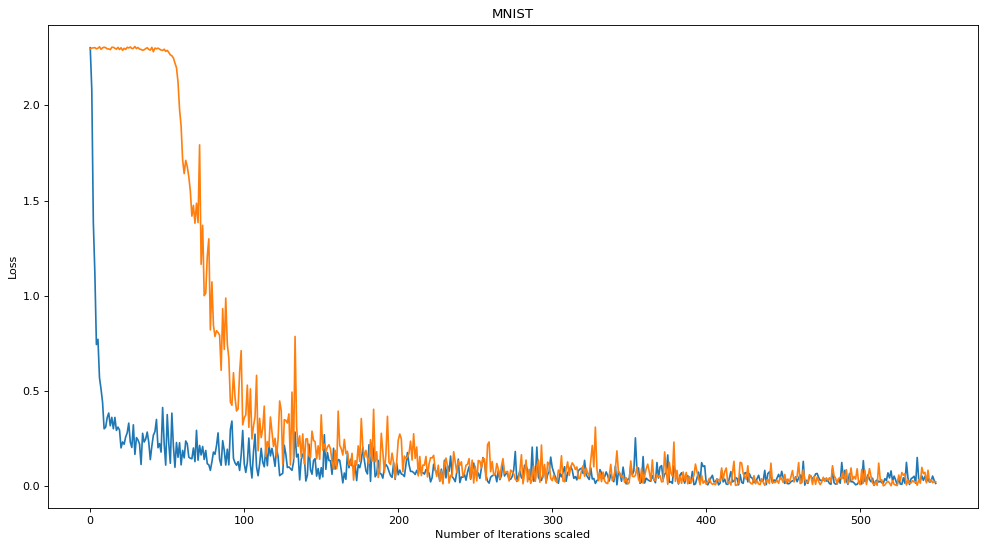

In [ ]:
figure(figsize=(15,8), dpi=80)

l3 = np.array(loss_list_with_skip_MNIST)
l4 = np.array(loss_list_withoutskip_MNIST)
iter_list = np.arange(550)

plt.plot(iter_list,l3,label = "with skips")
plt.plot(iter_list,l4,label = "without skips")
plt.xlabel("Number of Iterations scaled")
plt.ylabel("Loss")
plt.title("MNIST")

plt.show()

## CONCLUSIONS
We note the following conclusions:


1.   On CIFAR-10, the model with skip connections gave an accuracy of 49 whereas the model without skip connections gave an accuracy of around 42.5, clearly showing that skip connections lead to better performance on more complex problems. 
2.   On MNIST, since it is relatively simpler, even the model without skip is able to learn all the features that it needs to solve the problem.
3.   We also see from the graphs that the model with skip connections converges at a much faster pace, especially in the case of MNIST, where the model with skip connections reaches ~90% accuracy very quickly(<500 iterations), as opposed to the model without skip connections, which took >1000 iterations to reach the same levels of performance.
4.   Therefore, we note that skip connections help in speeding up the learning process of the model, as well as giving a higher accuracy in the case of complex datasets.



# Part 2
We now consider how different types of skip connections perform differently.
We shall be considering the following kinds of models:


1.   Simple addition
2.   Weighted addition
3.   Concatenation followed by transformation


This is a model which uses simple addition. The non-activated output from a previous layer is simply 
added to the ones ahead of it, after skipping a layer.

In [ ]:
class MLP_with_simple_addition_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_simple_addition_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3+out)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+out+out2)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out+out2+out4)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out+out2+out4+out6)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x)
        return out_final

We now create a model where before being added to further layers, the values are multiplied by weights. This is an extension of the previous model, but without using the outputs directly.

In [ ]:
class MLP_with_weighted_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_weighted_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

        self.skip1_w = nn.Linear(hidden_dim,hidden_dim)
        self.skip2_w = nn.Linear(hidden_dim,hidden_dim)
        self.skip3_w = nn.Linear(hidden_dim,hidden_dim)
        self.skip4_w = nn.Linear(hidden_dim,hidden_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        skip1 = self.skip1_w(out)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        skip2 = self.skip2_w(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3+skip1)
        skip3 = self.skip3_w(out4)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+skip1+skip2)
        skip4 = self.skip4_w(out6)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+skip1+skip2+skip3)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+skip1+skip2+skip3+skip4)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x)
        return out_final

The next and last model will be one where the values are concatenated to form a larger matrix, and then a weighted transformation occurs to the original dimensions.

In [ ]:
class MLP_with_concatenated_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_concatenated_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(3*hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(4*hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(5*hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)
        
    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        skip1_input = torch.cat((out,out3),dim = 1)
        out4 = self.fc3(skip1_input)
        out5 = self.ReLu(out4)
        skip2_input = torch.cat((out5,out2,out),dim = 1)
        out6 = self.fc4(skip2_input)
        out7 = self.ReLu(out6)
        skip3_input = torch.cat((out7,out4,out2,out),dim = 1)
        out8 = self.fc5(skip3_input)
        out9 = self.ReLu(out8)
        skip4_input = torch.cat((out9,out6,out4,out3,out),dim = 1)
        out10 = self.fc6(skip4_input)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x)
        return out_final

We now create instances of the models and see how they perform, and try to compare them against each other.

In [ ]:
torch.manual_seed(0)
model_with_simple_skips_CIFAR = MLP_with_simple_addition_skips(input_CIFAR,300,10)
model_with_weighted_skips_CIFAR = MLP_with_weighted_skips(input_CIFAR,300,10)
model_with_concatenated_skips_CIFAR = MLP_with_concatenated_skips(input_CIFAR,300,10)
model_with_simple_skips_MNIST = MLP_with_simple_addition_skips(input_MNIST,300,10)
model_with_weighted_skips_MNIST = MLP_with_weighted_skips(input_MNIST,300,10)
model_with_concatenated_skips_MNIST = MLP_with_concatenated_skips(input_MNIST,300,10)

if torch.cuda.is_available():
  model_with_simple_skips_CIFAR.to(device)
  model_with_weighted_skips_CIFAR.to(device)
  model_with_concatenated_skips_CIFAR.to(device)
  model_with_simple_skips_MNIST.to(device)
  model_with_weighted_skips_MNIST.to(device)
  model_with_concatenated_skips_MNIST.to(device)

In [ ]:
loss_model_simple_skips_CIFAR = []
loss_model_with_weighted_skips_CIFAR = []
loss_model_with_concatenated_skips_CIFAR = []
loss_model_simple_skips_MNIST = []
loss_model_with_weighted_skips_MNIST = []
loss_model_with_concatenated_skips_MNIST = []
iter_list = []

In [ ]:
print("Simple Skips on CIFAR------------------------")
train(model_with_simple_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_simple_skips_CIFAR)
print("Weighted Skips on CIFAR------------------------")
train(model_with_weighted_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_with_weighted_skips_CIFAR)
print("Concatenated Skips on CIFAR------------------------")
train(model_with_concatenated_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_with_concatenated_skips_CIFAR)
print("Simple Skips on MNIST------------------------")
train(model_with_simple_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_simple_skips_MNIST)
print("Weighted Skips on MNIST------------------------")
train(model_with_weighted_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_with_weighted_skips_MNIST)
print("Concatenated Skips on MNIST------------------------")
train(model_with_concatenated_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_with_concatenated_skips_MNIST)

Simple Skips on CIFAR------------------------
Iteration: 500. Loss: 1.9305131435394287. Accuracy: 36.14
Iteration: 1000. Loss: 1.7778990268707275. Accuracy: 37.88
Iteration: 1500. Loss: 1.6849305629730225. Accuracy: 40.56
Iteration: 2000. Loss: 1.6198736429214478. Accuracy: 43.74
Iteration: 2500. Loss: 1.5647671222686768. Accuracy: 44.32
Iteration: 3000. Loss: 1.3832508325576782. Accuracy: 46.24
Iteration: 3500. Loss: 1.4793096780776978. Accuracy: 44.96
Iteration: 4000. Loss: 1.3547086715698242. Accuracy: 47.0
Iteration: 4500. Loss: 1.509132981300354. Accuracy: 43.64
Weighted Skips on CIFAR------------------------
Iteration: 500. Loss: 1.8489941358566284. Accuracy: 29.26
Iteration: 1000. Loss: 1.6721922159194946. Accuracy: 39.18
Iteration: 1500. Loss: 1.5979069471359253. Accuracy: 38.94
Iteration: 2000. Loss: 1.506125807762146. Accuracy: 42.86
Iteration: 2500. Loss: 1.3502442836761475. Accuracy: 46.4
Iteration: 3000. Loss: 1.356022834777832. Accuracy: 45.32
Iteration: 3500. Loss: 1.632

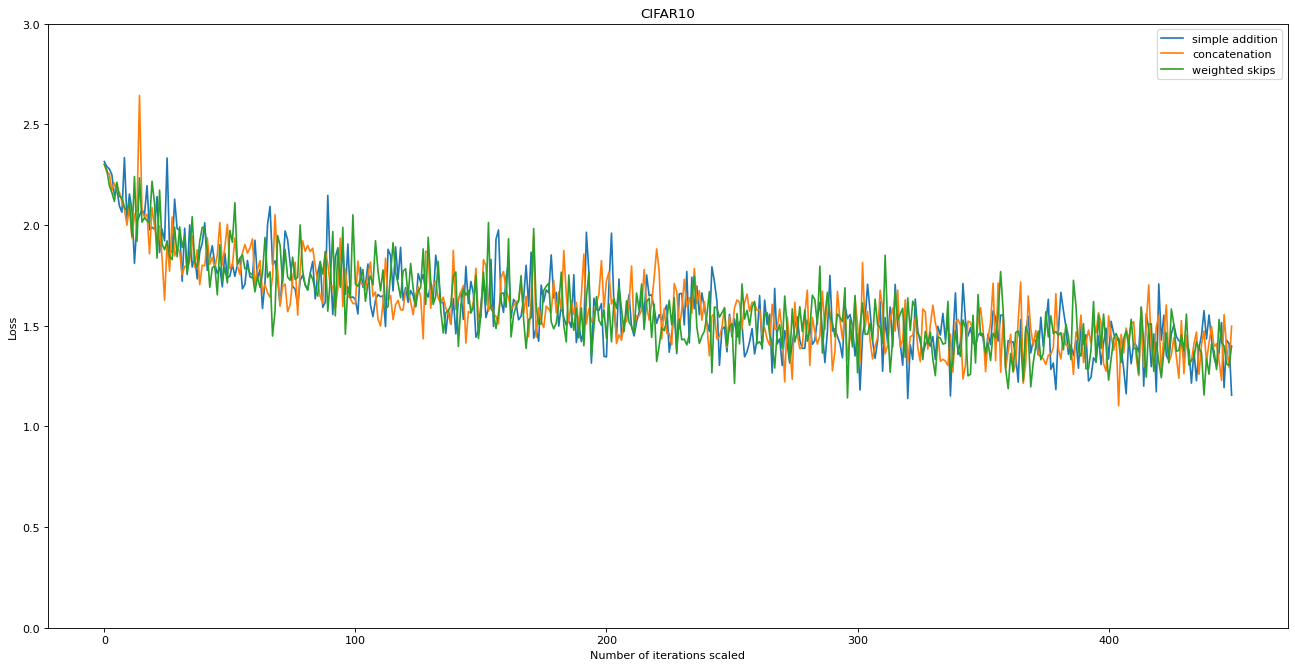

In [ ]:
figure(figsize=(20, 10), dpi=80)
l1 = np.array(loss_model_simple_skips_CIFAR)
l2 = np.array(loss_model_with_concatenated_skips_CIFAR)
l3 = np.array(loss_model_with_weighted_skips_CIFAR)
iter_list = np.arange(450)
plt.plot(iter_list,l1,label = "simple addition")
plt.plot(iter_list,l2,label = "concatenation")
plt.plot(iter_list,l3,label = "weighted skips")
plt.title("CIFAR10")
plt.xlabel("Number of iterations scaled")
plt.ylabel("Loss")
plt.ylim(0,3)
plt.legend()
plt.show()

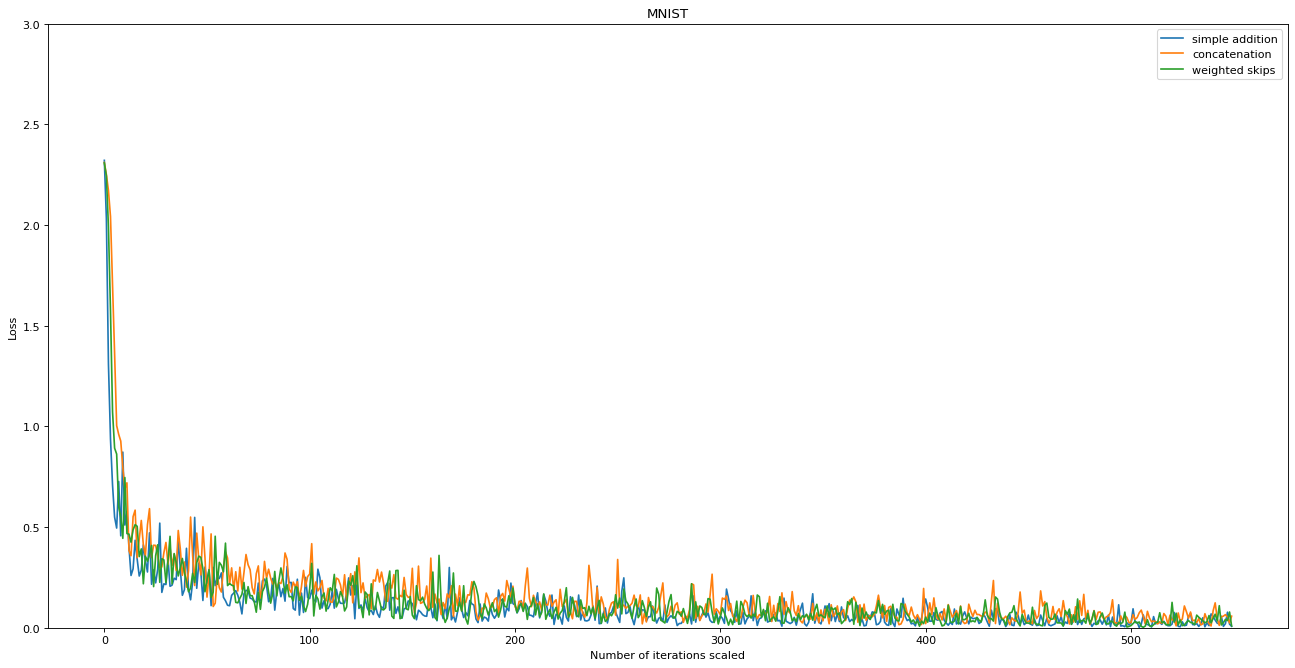

In [ ]:
figure(figsize=(20, 10), dpi=80)
l1 = np.array(loss_model_simple_skips_MNIST)
l2 = np.array(loss_model_with_concatenated_skips_MNIST)
l3 = np.array(loss_model_with_weighted_skips_MNIST)
iter_list = np.arange(550)
plt.plot(iter_list,l1,label = "simple addition")
plt.plot(iter_list,l2,label = "concatenation")
plt.plot(iter_list,l3,label = "weighted skips")
plt.title("MNIST")
plt.xlabel("Number of iterations scaled")
plt.ylabel("Loss")
plt.ylim(0,3)
plt.legend()
plt.show()

## CONCLUSIONS


1.   All three models give similar accuracies on both CIFAR(around 47%) and MNIST(around 98%).
2.   From the graph we see that the loss function for the model with concatenation fluctuates a lot. It finds it harder to converge on a local maximum.
3.   The one with simple addition appears to fluctuate less, which means that the gradients are more stable.



# Part 3
We now perform ablation studies on different kinds of skip connections, to see if there is a particular kind that gives the best results. 
We shall be considering the number of layers skipped as a parameter.

We start by using an MLP with simple addition skips, and we vary the number of layers skipped for each skip connection. Here, we have 3 kinds of models.

1.   Two layers skipped.
2.   Three layers skipped.
3.   Four layers skipped.


In [ ]:
class MLP_with_two_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_two_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3+out)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+out2)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out4)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out6)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x+out8)
        return out_final

In [ ]:
class MLP_with_three_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_three_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+out)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out2)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out4)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x+out6)
        return out_final

In [ ]:
class MLP_with_four_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_four_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out2)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x+out4)
        return out_final

We now create instances of the models and see how they perform.

In [ ]:
torch.manual_seed(0)
model_with_two_skips_CIFAR = MLP_with_two_skips(input_CIFAR,300,10)
model_with_three_skips_CIFAR = MLP_with_three_skips(input_CIFAR,300,10)
model_with_four_skips_CIFAR = MLP_with_four_skips(input_CIFAR,300,10)
model_with_two_skips_MNIST = MLP_with_two_skips(input_MNIST,300,10)
model_with_three_skips_MNIST = MLP_with_three_skips(input_MNIST,300,10)
model_with_four_skips_MNIST = MLP_with_four_skips(input_MNIST,300,10)

if torch.cuda.is_available():
  model_with_two_skips_CIFAR.to(device)
  model_with_three_skips_CIFAR.to(device)
  model_with_four_skips_CIFAR.to(device)
  model_with_two_skips_MNIST.to(device)
  model_with_three_skips_MNIST.to(device)
  model_with_four_skips_MNIST.to(device)

In [ ]:
loss_model_two_skips_CIFAR = []
loss_model_three_skips_CIFAR = []
loss_model_four_skips_CIFAR = []
loss_model_two_skips_MNIST = []
loss_model_three_skips_MNIST = []
loss_model_four_skips_MNIST = []
iter_list = []

In [ ]:
print("Model with two skips on CIFAR------------------------")
train(model_with_two_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_two_skips_CIFAR)
print("Model with three skips on CIFAR------------------------")
train(model_with_three_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_three_skips_CIFAR)
print("Model with four skips on CIFAR------------------------")
train(model_with_four_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_four_skips_CIFAR)

Model with two skips on CIFAR------------------------
Iteration: 500. Loss: 1.7201728820800781. Accuracy: 29.34
Iteration: 1000. Loss: 1.531266450881958. Accuracy: 32.7
Iteration: 1500. Loss: 1.8358651399612427. Accuracy: 39.76
Iteration: 2000. Loss: 1.5944275856018066. Accuracy: 40.08
Iteration: 2500. Loss: 1.4249643087387085. Accuracy: 44.02
Iteration: 3000. Loss: 1.8384792804718018. Accuracy: 43.28
Iteration: 3500. Loss: 1.4751005172729492. Accuracy: 45.86
Iteration: 4000. Loss: 1.1848149299621582. Accuracy: 47.86
Iteration: 4500. Loss: 1.4153324365615845. Accuracy: 44.52
Model with three skips on CIFAR------------------------
Iteration: 500. Loss: 2.1140799522399902. Accuracy: 28.82
Iteration: 1000. Loss: 1.6482222080230713. Accuracy: 38.82
Iteration: 1500. Loss: 1.533888339996338. Accuracy: 42.12
Iteration: 2000. Loss: 1.6846553087234497. Accuracy: 39.74
Iteration: 2500. Loss: 1.5711404085159302. Accuracy: 38.96
Iteration: 3000. Loss: 1.5400586128234863. Accuracy: 42.82
Iteration:

In [ ]:
print("Model with two skips on CIFAR10--------------------")
test(model_with_two_skips_CIFAR,test_loader_CIFAR,input_CIFAR)
print("Model with three skips on CIFAR10--------------------")
test(model_with_three_skips_CIFAR,test_loader_CIFAR,input_CIFAR)
print("Model with four skips on CIFAR10--------------------")
test(model_with_four_skips_CIFAR,test_loader_CIFAR,input_CIFAR)

Model with two skips on CIFAR10--------------------
 Test Accuracy =  45.36
Model with three skips on CIFAR10--------------------
 Test Accuracy =  46.800000000000004
Model with four skips on CIFAR10--------------------
 Test Accuracy =  49.43


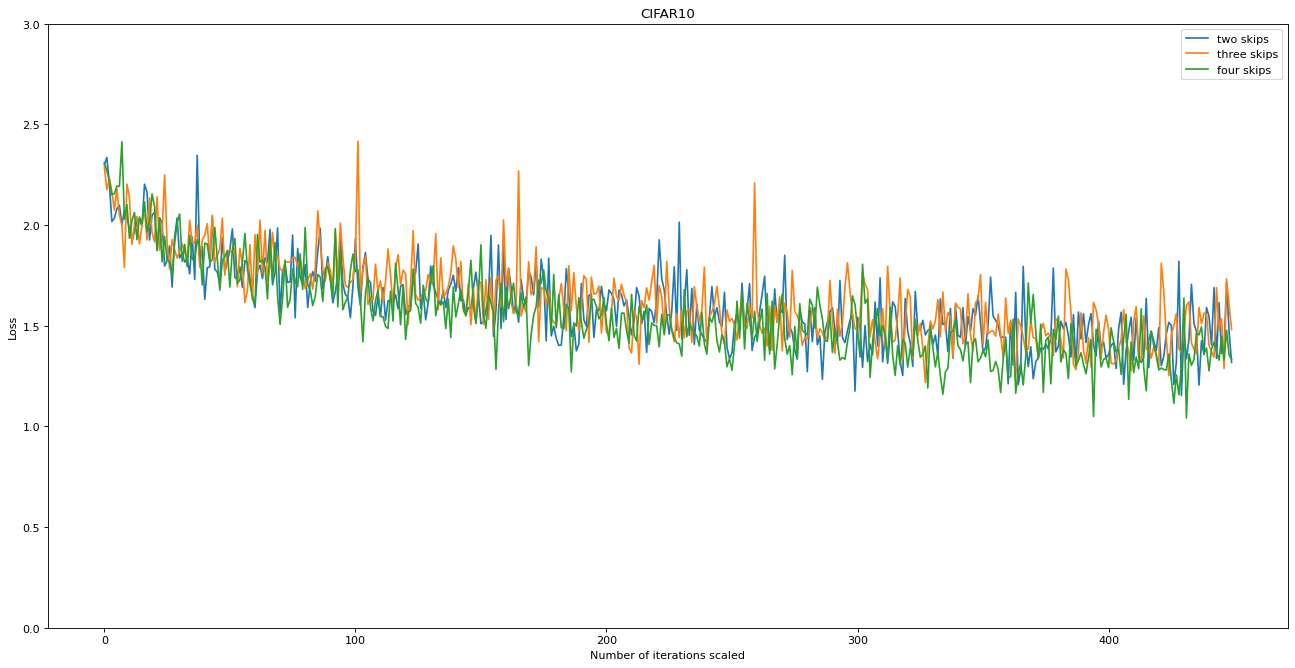

In [ ]:
figure(figsize=(20, 10), dpi=80)
l1 = np.array(loss_model_two_skips_CIFAR)
l2 = np.array(loss_model_three_skips_CIFAR)
l3 = np.array(loss_model_four_skips_CIFAR)
iter_list = np.arange(450)
plt.plot(iter_list,l1,label = "two skips")
plt.plot(iter_list,l2,label = "three skips")
plt.plot(iter_list,l3,label = "four skips")
plt.title("CIFAR10")
plt.xlabel("Number of iterations scaled")
plt.ylabel("Loss")
plt.ylim(0,3)
plt.legend()
plt.show()

In [ ]:
print("Model with two skips on MNIST------------------------")
train(model_with_two_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_two_skips_MNIST)
print("Model with three skips on MNIST------------------------")
train(model_with_three_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_three_skips_MNIST)
print("Model with four skips on MNIST------------------------")
train(model_with_four_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_four_skips_MNIST)

Model with two skips on MNIST------------------------
Iteration: 500. Loss: 0.2037457823753357. Accuracy: 93.18
Iteration: 1000. Loss: 0.31409329175949097. Accuracy: 94.98
Iteration: 1500. Loss: 0.11912067234516144. Accuracy: 96.88
Iteration: 2000. Loss: 0.10637245327234268. Accuracy: 96.96
Iteration: 2500. Loss: 0.06525132060050964. Accuracy: 97.42
Iteration: 3000. Loss: 0.06445366144180298. Accuracy: 97.48
Iteration: 3500. Loss: 0.17888428270816803. Accuracy: 97.42
Iteration: 4000. Loss: 0.0795455276966095. Accuracy: 96.88
Iteration: 4500. Loss: 0.018560610711574554. Accuracy: 97.9
Iteration: 5000. Loss: 0.0034149696584790945. Accuracy: 98.14
Iteration: 5500. Loss: 0.015858538448810577. Accuracy: 98.0
Model with three skips on MNIST------------------------
Iteration: 500. Loss: 0.2705308198928833. Accuracy: 92.0
Iteration: 1000. Loss: 0.20027591288089752. Accuracy: 94.02
Iteration: 1500. Loss: 0.2235243022441864. Accuracy: 95.06
Iteration: 2000. Loss: 0.1618189960718155. Accuracy: 96

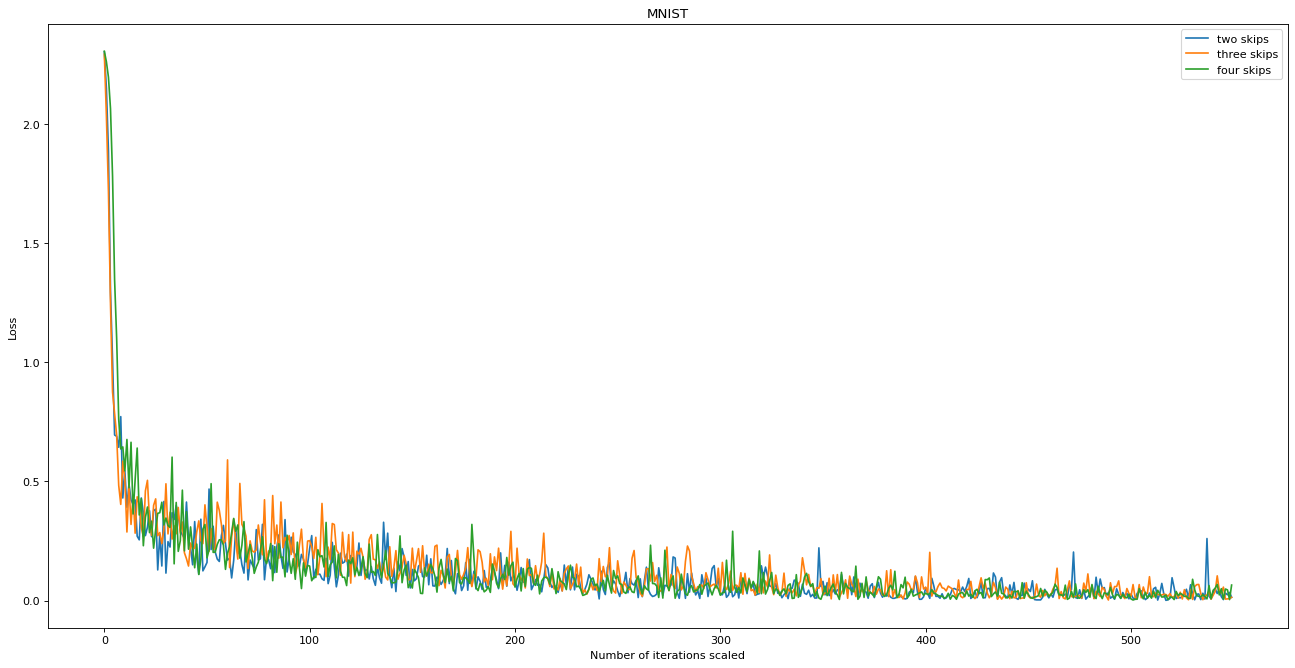

In [ ]:
figure(figsize=(20, 10), dpi=80)
l1 = np.array(loss_model_two_skips_MNIST)
l2 = np.array(loss_model_three_skips_MNIST)
l3 = np.array(loss_model_four_skips_MNIST)
iter_list = np.arange(550)
plt.plot(iter_list,l1,label = "two skips")
plt.plot(iter_list,l2,label = "three skips")
plt.plot(iter_list,l3,label = "four skips")
plt.title("MNIST")
plt.xlabel("Number of iterations scaled")
plt.ylabel("Loss")
plt.legend()
plt.show()

## CONCLUSIONS


1.   For CIFAR10, the model with four skips had a better performance on the data(49.5% accuracy) when compared to the model with 2 and 3 skips(around 46% accuracy).
2.   Looking at the graph of the models on CIFAR10 and MNIST, we noted that the loss of the model with 3 skips fluctuated a lot and often ended up higher than the model with 2 skips. The cause for this is unclear.
3.   Also, for MNIST, the model with 2 skips initially seemed to learn faster, but eventually all models converged to a similar minimum loss.




#Part-4
Skip connections provide better performance as they enable feature reusability. In a model with many layers, the features learnt in the earliest layers are no longer taken into account for layers deeper in the model. With skip connections, we can feed the values outputted by these layers to layers close to the output, which gives them more weight in the final result. 

The models with skip connections also seem to converge much faster. Skip connections increase the magnitude of the gradients, which means that there is less scope for vanishing gradients. Because these gradients are larger, they lead to the model learning faster, which leads to a faster convergence. 

In Part-1, when we compared the performances of the model with skips and without skips, we noticed these advantages of skip connections. 